# Improving Company's Collaboration
An analysis of a company's six months of information on inter-employee communication using python networkx. The dataset was assessed for errors and cleared of duplicates and merged into a single master dataset. The communication between six departments (Sales, Operations, IT, Admin, Marketing and Operations) and about 664 unique employee id's. The analysis involved creating a network visualization of the messages sent by each employee from a department to another employee in the same or different department. This was to determine the relationships between employees and also find out areas to improve collaboration within the department or with another department.

Extensive analysis was performed to determine the most active department, in this case was the **Sales** department. The results also showed that the employee with id **598**, aside being among the top five most influential employee (including id's 128, 605 and 586) also has the most connections. Whilst the **Sales** department is also the most influential department, more collaborative measures should be implemented to improve collaboration in the IT and Marketing departments.

The messages sent within the six months period under study had a huge decline as the month progressed as shown in the trend plot.

The following features are contained in the dataset:
#### Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

#### Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx
import warnings
from networkx.algorithms.community import label_propagation_communities as LPC

%matplotlib inline
sb.set_theme(style = 'whitegrid')
warnings.filterwarnings('ignore')

In [2]:
# Loading datasets
messages = pd.read_csv('data/messages.csv', parse_dates = ['timestamp'])
employees = pd.read_csv('data/employees.csv')

# Data Assessing
**The data (messages and employees) will be assessed to ascertain if it is clean or not.**

**First, a copy of the original data will be made for this process and further down. This is to have easy access to the original data when the need arises.**

In [3]:
# Copying data
messages_sent = messages.copy()
employees_data = employees.copy()

#### Checking for missing values

In [4]:
print(messages_sent.info())
print(employees_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sender          3512 non-null   int64         
 1   receiver        3512 non-null   int64         
 2   timestamp       3512 non-null   datetime64[ns]
 3   message_length  3512 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 109.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          664 non-null    int64 
 1   department  664 non-null    object
 2   location    664 non-null    object
 3   age         664 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.9+ KB
None


**The messages_sent and employees_data have no missing values as observed from the results obtained above. The columns also have appropriate data types assigned to them. The timestamp has datetime64[ns] as its data type, sender and receiver both integers, and same goes with other features in the data set.**

**One issue arises, though trivial but important, sender and receiver in the messages_sent data both indicate the sender and receiver of the message(s) respectively, but are actually the id of both, thus the columns will be renamed to sender_id and receiver_id respectively. This is to properly communicate what the feature (column) actually contains.**

In [5]:
# Renaming columns
messages_sent.rename(columns = {'sender':'sender_id', 'receiver':'receiver_id'}, inplace = True)
messages_sent.head(2)

,sender_id,receiver_id,timestamp,message_length
0,79,48,2021-06-02 05:41:34,88
1,79,63,2021-06-02 05:42:15,72


In [6]:
employees_data.head(2)

,id,department,location,age
0,3,Operations,US,33
1,6,Sales,UK,50


#### Checking for duplicates

In [7]:
messages_sent.duplicated().sum()

3

In [8]:
employees_data.duplicated().sum()

0

**Exploring further on duplicated values**

In [9]:
# Create a new column `duplicate_values` to check and print duplicates
duplicate_values = messages_sent.duplicated(keep = False)
messages_sent[duplicate_values]

,sender_id,receiver_id,timestamp,message_length
3333,1807,32,2021-10-13 22:25:17,50
3365,1657,1675,2021-11-02 07:42:25,52
3377,1881,1676,2021-11-17 06:45:28,27
3446,1807,32,2021-10-13 22:25:17,50
3478,1657,1675,2021-11-02 07:42:25,52
3490,1881,1676,2021-11-17 06:45:28,27


**From all indications, the values are duplicated and thus will be dropped. This decision was taken because a particular sender (sender_id) cannot send the same exact message with the same message length, at the same date and same exact timestamp, to the same receiver (receiver_id). In real time, there must have been a difference in the time in seconds.**

In [10]:
# Drop duplicates
messages_sent = messages_sent.drop_duplicates()

# check
messages_sent.duplicated().sum()

0

# Merging Datasets
**The `messages_sent` and `employee_data` will be merged using the `sender_id`, `receiver_id` and `id`. In order to achieve a successful merge, the dataframe's must have a common key, in this case, sender_id, receiver_id and id.**

**One issue arises: the key columns do not have same name. In order to resolve this, feature engineering will be used to copy the sender_id and receiver_id to a new column named `id` in the message_sent dataframe. This column will be dropped once the merge is completed since it is a copy of an already existing feature.**

**The merge will use a `left join` as this will filter all the messages sent by each employee using the sender_id, including their details and receiver_id too.**

>NOTE: The data in the sender_id, receiver_id and the feature engineered id column is the same, only a change of name to enable merging the two data frames. The id column will be dropped after.

In [11]:
# Feature engineering: new column named 'id' in messages_sent for sender_id
messages_sent['id'] = messages_sent['sender_id']

# Merging data frames using 'left join' on 'id'
df_x = pd.merge(messages_sent, employees_data, how = 'left', on = 'id')

# Dropping feature engineered column: id
df_x.drop('id', axis = 1, inplace = True)

# Feature engineering: new column named 'id' in messages_sent for receiver_id
df_x['id'] = df_x['receiver_id']

# Merging data frames using 'left join' on 'id'
df = pd.merge(df_x, employees_data, how = 'left', on = 'id')

# Dropping feature engineered column: id
df.drop('id', axis = 1, inplace = True)

# Check for duplicated values
print('There are {} duplicated values'.format(df_x.duplicated().sum()))

# First two rows of merged data frame
df.head(2)

There are 0 duplicated values


,sender_id,receiver_id,timestamp,message_length,department_x,location_x,age_x,department_y,location_y,age_y
0,79,48,2021-06-02 05:41:34,88,Sales,France,33,IT,France,34
1,79,63,2021-06-02 05:42:15,72,Sales,France,33,Sales,France,38


**The following modifications will be made to make the dataframe suitable for our analysis:**
- department_x and department_y will be renamed to sender_department and receiver_department respectively
- location_x and location_y will be renamed to sender_location and receiver_location respectively
- age_x and age_y will be renamed to sender_age and receiver_age respectively
- A new column 'month' will be created from the timestamp so the trend of messages sent and received by each department can be visualized

In [12]:
# Renaming dataframe columns:
df.rename(columns = {'department_x':'sender_department', 'department_y':'receiver_department',
                     'location_x':'sender_location', 'location_y':'receiver_location',
                     'age_x':'sender_age', 'age_y':'receiver_age'}, inplace = True)

# Extract the month form the timestamp
df['month'] = df['timestamp'].dt.month

# First 2 rows of the new data frame
df.head(2)

,sender_id,receiver_id,timestamp,message_length,sender_department,sender_location,sender_age,receiver_department,receiver_location,receiver_age,month
0,79,48,2021-06-02 05:41:34,88,Sales,France,33,IT,France,34,6
1,79,63,2021-06-02 05:42:15,72,Sales,France,33,Sales,France,38,6


**The final dataframe obtained contains detailed information needed for our analysis. From the dataframe, details about the sender and receiver (id, department, location, and age) can easily be obtained.**

**The final dataframe will be saved as a master data. This is to have easy access to the data used for the analysis and avoid repeating the process before hand.**

In [13]:
# Saving final data set
df.to_csv('data/master_data_set.csv', index = False)

# Exploratory Data Analysis

**In this section, we will make use of the already prepared `master_data_set` as it contains all information needed to derive insights and make decisions.**

In [14]:
# Loading master data set
df = pd.read_csv('data/master_data_set.csv', parse_dates = ['timestamp'])

### Descriptive Statistics

In [15]:
describe_df = df[['message_length', 'sender_age', 'receiver_age']]
describe_df.describe()

,message_length,sender_age,receiver_age
count,3509.000000,3509.000000,3509.000000
mean,48.455400,38.943574,41.065546
std,22.864271,8.340714,10.398350
min,10.000000,23.000000,22.000000
25%,29.000000,31.000000,33.000000
50%,49.000000,38.000000,41.000000
75%,68.000000,47.000000,50.000000
max,88.000000,59.000000,59.000000


**The table shows a distribution of selected numeric columns from the data set: message_length, sender_age and receiver_age. Statistical values as the mean, standard deviation, minimum values, maximum values, 25%, 50% (median) and 75% percentiles can be obtained. One striking observation is the difference in the distribution of these values for the sender_age and receiver_age. At first, before performing the descriptive statistics, one can easily make a wrong assumption that these values might not vary owing to the fact that it is within the same establishment and among the same employees.**

## 1. Which departments are the most/least active?

**The most/least active department can come from both the receiving and the sending departments. Considering the origin of the message (sending department), there is a department that is most active, and also a department that is least active. This is same when considering the destination (receiving department) of the messages.**

In [16]:
# Get count of number of times each department sent a message
sending_departments = df.groupby(['sender_department'])['sender_id', 'timestamp'].count().sort_values('sender_id', ascending = False)
sending_departments.rename(columns = {'timestamp':'message_count'}, inplace = True)
active_department_by_sender = sending_departments[['message_count']]
active_department_by_sender

,message_count
sender_department,
Sales,1549
Operations,1013
Admin,856
IT,49
Engineering,26
Marketing,16


**With reference to the sending department, the _most active_ is the _Sales Department_ with a total message count of _1549_ for the period of six months. This might be attributed to the fact that they engage in sales of the company product(s) and constantly need updates on different products from different departments. The _least active_ department is the _Marketing Department_ with a total message count of _16_ for the six months period under study.**

In [17]:
# Get count of number of times each department received a message
receiving_departments = df.groupby(['receiver_department'])['receiver_id', 'timestamp'].count().sort_values('receiver_id', ascending = False)
receiving_departments.rename(columns = {'timestamp':'message_count'}, inplace = True)
active_department_by_receiver = receiving_departments[['message_count']]
active_department_by_receiver

,message_count
receiver_department,
Sales,1227
Operations,845
Admin,797
Engineering,251
IT,249
Marketing,140


**At the receiving end, the _Sales Department_ is still the most active with a total message count of _1227_. The _Marketing Department_ is still the _least active_ in this aspect with a message count of _140_, though with a huge increase compared with the sending department.**

**Visualizing the above results:**

In [18]:
# Creating a count plot function for visualization and to avoid code repetition
def count_plot(dataframe, feature, title, x_label, y_label, order):
    """
    A function that plots the count of a feature in a given dataframe using seaborn countplot.
    
    Args:
        dataframe: Dataframe from which data will be plotted.
        feature: Column to be plotted
        title: Histogram title inputed as string with quoatation marks.
        x_label: x_axis label inputed as string with quoatation marks.
        y_label: y_axis label inputed as string with quoatation marks.
        order: Order in which the data will be plotted. If the data is to be plotted in no order, input 'None'.
    """
    sb.countplot(data = dataframe, x = feature, color = sb.color_palette()[0], order = order)
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel(y_label, fontsize = 15)
    plt.xticks(size = 10)
    plt.yticks(size = 10)

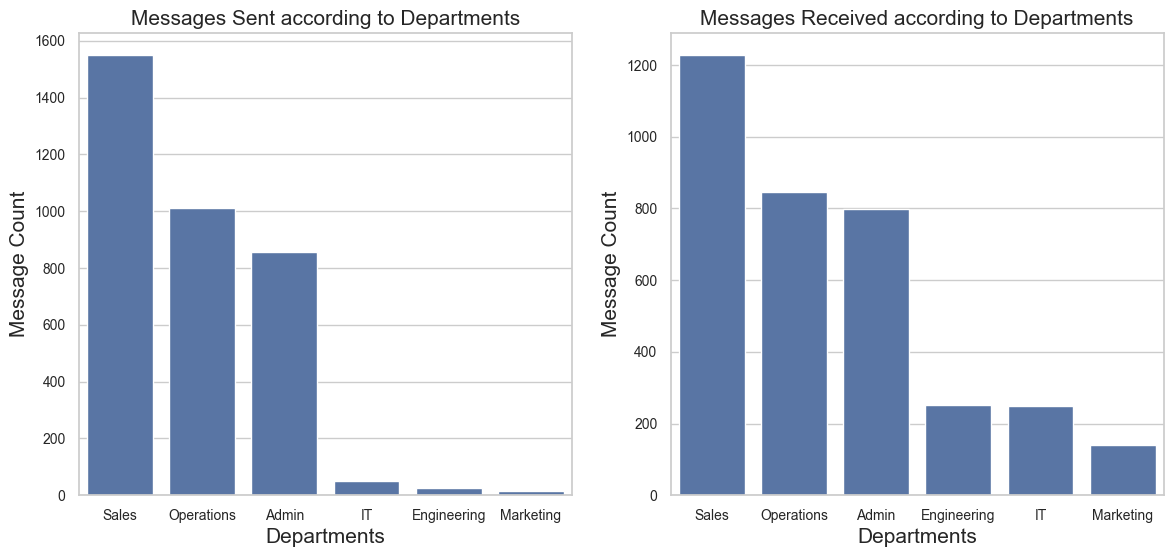

In [19]:
# Sender department
plt.figure(figsize = [14, 6])
plt.subplot(1,2,1)
order = df.sender_department.value_counts().index
count_plot(df, 'sender_department', 'Messages Sent according to Departments', 'Departments', 'Message Count', order)

# Receiver department
plt.subplot(1,2,2)
order = df.receiver_department.value_counts().index
count_plot(df, 'receiver_department', 'Messages Received according to Departments', 'Departments', 'Message Count', order)

**From the visualization, one can easily infer how all the departments performed from the sending and receiving perspectives.**

## 2. Which employee(s) has the most connections?
Using pythons networkx, the connectivity an employee has is measured as degree.

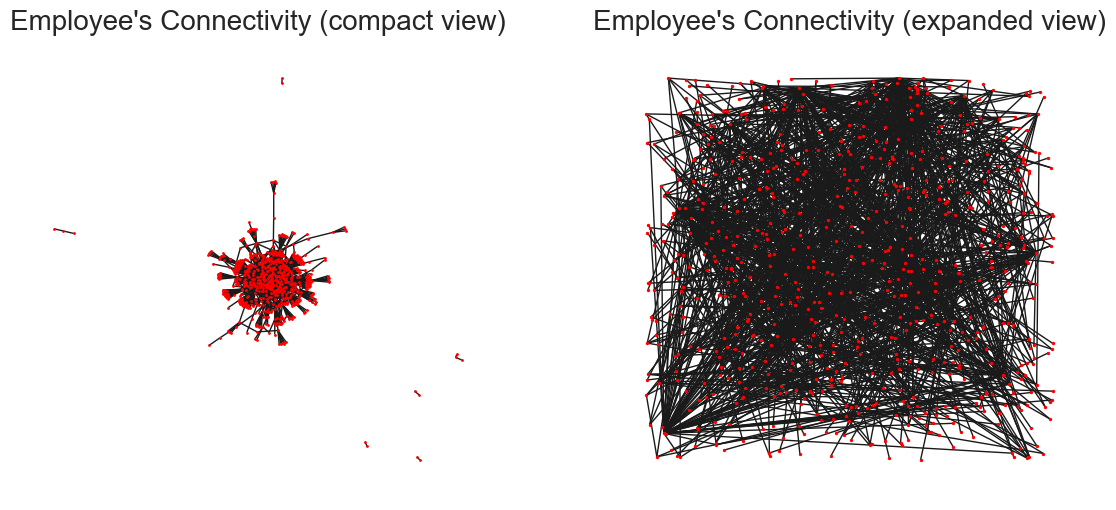

In [20]:
# Connectivity network graph
connectivity = nx.Graph()
connectivity.add_nodes_from(list(df.sender_id))
connectivity.add_edges_from([(df.sender_id[i], df.receiver_id[i]) for i in range(0, df.shape[0])])

plt.figure(figsize = [14, 6])
plt.subplot(1, 2, 1)
nx.draw(connectivity, node_size = 1, node_color = 'red', with_labels = False)
plt.title("Employee's Connectivity (compact view)", fontsize = 20)

plt.subplot(1, 2, 2)
nx.draw_random(connectivity, node_size = 2, node_color = 'red', with_labels = False)
plt.title("Employee's Connectivity (expanded view)", fontsize = 20)
plt.show()

Each red dot (node) represents a unique employee (sender_id), each connected by lines (edges). This shows the connections each employee (sender_id) has. Using the _degree()_ method in networkx, we can find the employee(s) with the most connections.

In [21]:
# Employee(s) with most connections
most_connections = list(zip(dict(connectivity.degree()).values(), dict(connectivity.degree()).keys()))
most_connections = sorted(most_connections, key = lambda x: x[0], reverse = True)
print(most_connections[:5])

[(81, 598), (76, 144), (72, 128), (68, 605), (64, 586)]


**The employee(s) with the most connections, taking the top five (5) are:**
1. Employee with id **598** having **81** connections
2. Employee with id **144** having **76** connections
3. Employee with id **128** having **72** connections
4. Employee with id **605** having **68** connections
5. Employee with id **586** having **64** connections

The employee with most connections is **598** with **81** connections.

## 3. Identify the most influential departments and employees.
### - **Most influential department(s):** The three measures of centrality are used:
- degree centrality
- eigenvector centrality
- betweenness centrality

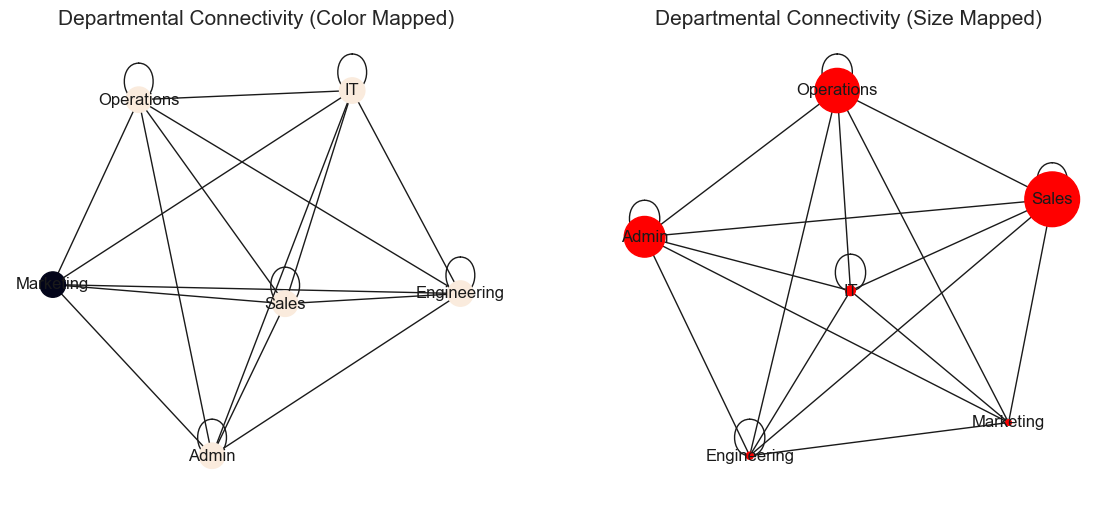

In [22]:
# Most influential departments
most_influential_department = nx.Graph()
most_influential_department.add_nodes_from(list(df.sender_department))
most_influential_department.add_edges_from([(df.sender_department[i], df.receiver_department[i]) for i in range(0, df.shape[0])])
pos = nx.spring_layout(most_influential_department)
bet_cent = nx.betweenness_centrality(most_influential_department, normalized = True, endpoints = True)
node_color = [most_influential_department.degree(d) for d in most_influential_department]
node_size =  [n * 1000 for n in bet_cent.values()]

plt.figure(figsize = [14, 6])
plt.subplot(1, 2, 1)
nx.draw_networkx(most_influential_department,
                  with_labels = True,
                 node_color = node_color,
                 node_size = node_size )
plt.title("Departmental Connectivity (Color Mapped)", fontsize = 15)
plt.axis('off')

plt.subplot(1, 2, 2)
nx.draw_networkx(most_influential_department,
                 node_size = df.sender_department.value_counts(sort = False),
                 node_color = 'red', with_labels = True)
plt.title("Departmental Connectivity (Size Mapped)", fontsize = 15)
plt.axis('off')
plt.show()

In [23]:
deg_cent = nx.degree_centrality(most_influential_department)
eig_cent = nx.eigenvector_centrality(most_influential_department)

print('Betweenness Centrality: ', sorted(bet_cent, key = bet_cent.get, reverse = True))
print('Eigenvector Centrality: ', sorted(eig_cent, key = eig_cent.get, reverse = True))
print('Degree Centrality:      ', sorted(deg_cent, key = deg_cent.get, reverse = True))

Betweenness Centrality:  ['Sales', 'Operations', 'Engineering', 'IT', 'Admin', 'Marketing']
Eigenvector Centrality:  ['Sales', 'Operations', 'Engineering', 'IT', 'Admin', 'Marketing']
Degree Centrality:       ['Sales', 'Operations', 'Engineering', 'IT', 'Admin', 'Marketing']


The most influential department is the **Sales** department.

The top 3 most influential departments are:
1. **Sales**
2. **Operations**
3. **Engineering**

### - **Most influential employee(s):** Three parameters are used in calculating the most influential individual in a network: degree centrality, eigenvector centrality and betweenness centrality. These parameters take into consideration the number of people a node(employee) is connected to, the type of people they are connected to and the centrality of control.

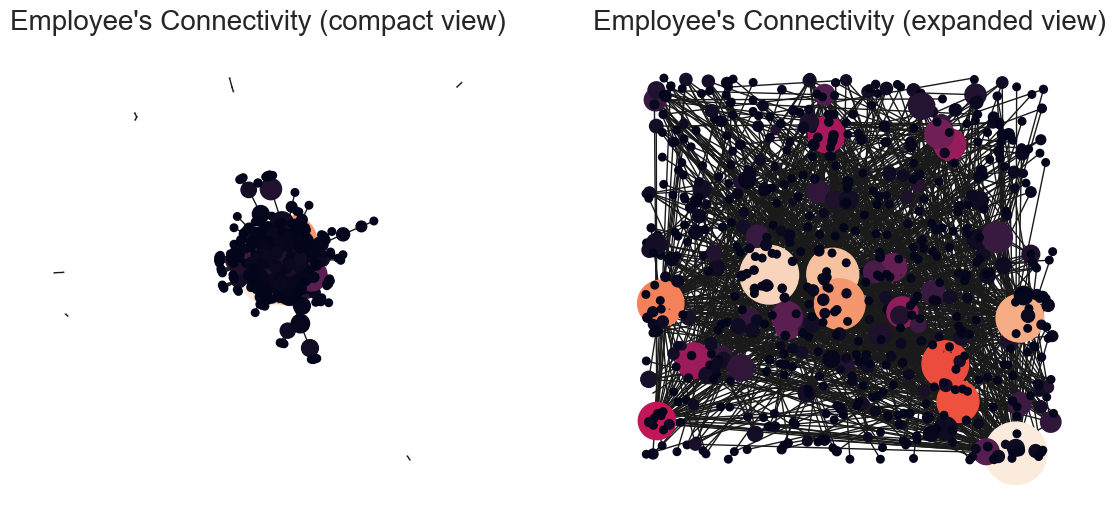

In [24]:
# Most influential employees
most_influential_employee = nx.Graph()
most_influential_employee.add_nodes_from(list(df.sender_id))
most_influential_employee.add_edges_from([(df.sender_id[i], df.receiver_id[i]) for i in range(0, df.shape[0])])
pos = nx.spring_layout(most_influential_employee)
bet_cent = nx.betweenness_centrality(most_influential_employee, normalized = True, endpoints = True)
node_color = [most_influential_employee.degree(e) for e in most_influential_employee]
node_size =  [n * 10000 for n in bet_cent.values()]
plt.figure(figsize = [14, 6])
plt.subplot(1, 2, 1)
nx.draw_networkx(most_influential_employee,
                  with_labels = False,
                 node_color = node_color,
                 node_size = node_size )
plt.title("Employee's Connectivity (compact view)", fontsize = 20)
plt.axis('off')

plt.subplot(1, 2, 2)
nx.draw_random(most_influential_employee,
                  with_labels = False,
                 node_color = node_color,
                 node_size = node_size )
plt.title("Employee's Connectivity (expanded view)", fontsize = 20)
plt.axis('off')
plt.show()

In [25]:
deg_cent = nx.degree_centrality(most_influential_employee)
eig_cent = nx.eigenvector_centrality(most_influential_employee)

print('Betweenness Centrality: ', sorted(bet_cent, key = bet_cent.get, reverse = True)[:5])
print('Eigenvector Centrality: ', sorted(eig_cent, key = eig_cent.get, reverse = True)[:5])
print('Degree Centrality:      ', sorted(deg_cent, key = deg_cent.get, reverse = True)[:5])

Betweenness Centrality:  [598, 144, 128, 586, 605]
Eigenvector Centrality:  [598, 389, 128, 605, 586]
Degree Centrality:       [598, 144, 128, 605, 586]


**From the above parameters, the most influential employees (employees that meet the three centrality measures) are:**
1. Employee with id **598** in the **Operations department.**
2. Employee with id **128** in the **Sales department.**
3. Employee with id **605** in the **Admin department.**
4. Employee with id **586** in the **Operations department.**

## 4. Using the network analysis, in which departments would you recommend the HR team focus to boost collaboration?

From the analysis carried out, the HR should channel more resources to boost collaboration in the Marketing and IT departments. This recommendation is owed to the results obtained from the network analysis, where the two departments mentioned had the least centrality measures among the six departments.

## 5. Visualization for messages sent and received by each department for the duration.

In [26]:
# Creating a plot function for visualization and to avoid code repetition
def line_plot(dataframe, x_value, y_value, hue, title, x_label, y_label):
    """
    A function that plots a feature in a given dataframe using seaborn lineplot.
    
    Args:
        dataframe: Dataframe from which data will be plotted.
        x_value: Feature to be plotted on x_axis
        y_value: Feature to be plotted on y_axis
        title: Histogram title inputed as string with quoatation marks.
        x_label: x_axis label inputed as string with quoatation marks.
        y_label: y_axis label inputed as string with quoatation marks.
        order: Order in which the data will be plotted. If the data is to be plotted in no order, input 'None'.
    """
    sb.lineplot(data = dataframe, x = x_value, y = y_value, hue = hue, marker = 'o')
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel(y_label, fontsize = 15)
    plt.xticks(size = 10)
    plt.yticks(size = 10)
    plt.grid(None)

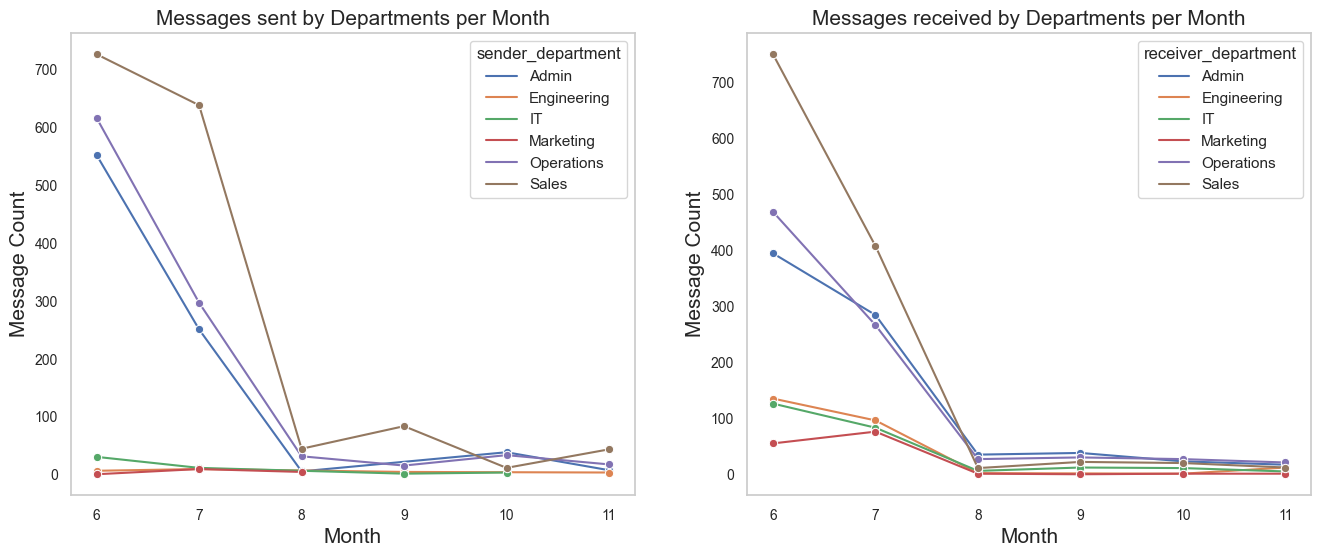

In [27]:
# Messages sent by each department per month
plt.figure(figsize = [16, 6])
plt.subplot(1,2,1)
messages_sent_by_dept_per_month = df.groupby(['sender_department', 'month'])[['timestamp']].count()
line_plot(messages_sent_by_dept_per_month, 'month', 'timestamp', 'sender_department', 'Messages sent by Departments per Month', 'Month', 'Message Count')

# Messages received by each department per month
plt.subplot(1,2,2)
messages_received_by_dept_per_month = df.groupby(['receiver_department', 'month'])[['timestamp']].count()
line_plot(messages_received_by_dept_per_month, 'month', 'timestamp', 'receiver_department', 'Messages received by Departments per Month', 'Month', 'Message Count')

**The above visualization depicts the count of messages sent and received by each department per month. The _Sales Department_ clearly takes the lead in both scenarios. There are lots of messages sent and received in the sixth month, which tailed down towards the seventh month and with a relative little changes from the eight month to the eleventh month.**